[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-4/research-assistant.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239974-lesson-4-research-assistant)

# Research Assistant

## Review

We've covered a few major LangGraph themes:

* Memory
* Human-in-the-loop
* Controllability

Now, we'll bring these ideas together to tackle one of AI's most popular applications: research automation.

Research is often laborious work offloaded to analysts. AI has considerable potential to assist with this.

However, research demands customization: raw LLM outputs are often poorly suited for real-world decision-making workflows.

Customized, AI-based [research and report generation](https://jxnl.co/writing/2024/06/05/predictions-for-the-future-of-rag/#reports-over-rag) workflows are a promising way to address this.

## Goal

Our goal is to build a lightweight, multi-agent system around chat models that customizes the research process.

`Source Selection`
* Users can choose any set of input sources for their research.
  
`Planning`
* Users provide a topic, and the system generates a team of AI analysts, each focusing on one sub-topic.
* `Human-in-the-loop` will be used to refine these sub-topics before research begins.
  
`LLM Utilization`
* Each analyst will conduct in-depth interviews with an expert AI using the selected sources.
* The interview will be a multi-turn conversation to extract detailed insights as shown in the [STORM](https://arxiv.org/abs/2402.14207) paper.
* These interviews will be captured in a using `sub-graphs` with their internal state.
   
`Research Process`
* Experts will gather information to answer analyst questions in `parallel`.
* And all interviews will be conducted simultaneously through `map-reduce`.

`Output Format`
* The gathered insights from each interview will be synthesized into a final report.
* We'll use customizable prompts for the report, allowing for a flexible output format.

![Screenshot 2024-08-26 at 7.26.33 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb164d61c93d48e604091_research-assistant1.png)

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langchain_community langchain_core tavily-python wikipedia

## Setup

In [15]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("open ai API key to be placed here")

KeyboardInterrupt: Interrupted by user

In [ ]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("Open ai api key is to be used here ")


We'll use [LangSmith](https://docs.langchain.com/langsmith/home) for [tracing](https://docs.langchain.com/langsmith/observability-concepts).

In [ ]:
_set_env("Lang key is to be used here ")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

## Generate Analysts: Human-In-The-Loop

Create analysts and review them using human-in-the-loop.

In [ ]:
from pydantic import BaseModel, Field

class Analyst(BaseModel):
    name: str
    role: str
    affiliation: str
    specialization: str
    description: str
    confidence_score: float = 0.8

    @property
    def persona(self) -> str:
        return (
            f"Name: {self.name}\n"
            f"Role: {self.role}\n"
            f"Affiliation: {self.affiliation}\n"
            f"Specialization: {self.specialization}\n"
            f"Confidence: {self.confidence_score}\n"
            f"Description: {self.description}\n"
        )


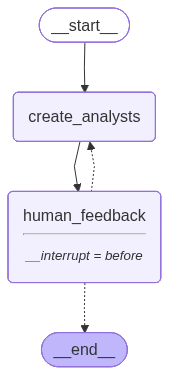

In [ ]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# ----------------------------- Dummy LLM Setup -----------------------------
class DummyLLM:
    """Simulated LLM to work without API key"""
    def with_structured_output(self, model):
        return self

    def invoke(self, messages):
        # Create mock analysts to simulate real LLM structured output
        mock_analysts = [
            {"name": "Dr. Mira Chen", "role": "AI Policy Analyst", "affiliation": "Tech Policy Lab", "specialization": "Ethical AI frameworks"},
            {"name": "Prof. Raj Patel", "role": "Data Scientist", "affiliation": "Open Data Institute", "specialization": "Data transparency and analysis"},
            {"name": "Elena Rossi", "role": "Machine Learning Engineer", "affiliation": "NeuralWorks", "specialization": "Model optimization and deployment"}
        ]
        class MockOutput:
            analysts = [Analyst(**a) for a in mock_analysts]
        return MockOutput()

# Replace ChatOpenAI with DummyLLM
llm = DummyLLM()

# ----------------------------- Data Models -----------------------------
class Analyst(BaseModel):
    name: str = Field(description="Name of the analyst.")
    role: str = Field(description="Role of the analyst in the context of the topic.")
    affiliation: str = Field(description="Primary affiliation of the analyst.")
    specialization: str = Field(description="Area of specialization for the analyst.")

    @property
    def persona(self) -> str:
        return (
            f"Name: {self.name}\n"
            f"Role: {self.role}\n"
            f"Affiliation: {self.affiliation}\n"
            f"Specialization: {self.specialization}\n"
        )

class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(
        description="List of analysts with their details and expertise areas."
    )

class GenerateAnalystsState(TypedDict):
    topic: str
    max_analysts: int
    human_analyst_feedback: str
    analysts: List[Analyst]

# ----------------------------- Analyst Creation Logic -----------------------------
analyst_instructions = """
You are tasked with creating AI analyst personas. Follow these structured steps:

1. Review the research topic carefully: {topic}
2. Consider human feedback (if any): {human_analyst_feedback}
3. Identify unique subtopics relevant to the research area.
4. Create {max_analysts} analysts, each specializing in a distinct aspect.
5. Define clear name, affiliation, role, and specialization for each analyst.
"""

def create_analysts(state: GenerateAnalystsState):
    """Create analysts using simulated LLM structured output"""
    topic = state["topic"]
    max_analysts = state["max_analysts"]
    human_analyst_feedback = state.get("human_analyst_feedback", "")

    structured_llm = llm.with_structured_output(Perspectives)
    system_message = analyst_instructions.format(
        topic=topic,
        human_analyst_feedback=human_analyst_feedback,
        max_analysts=max_analysts
    )

    analysts = structured_llm.invoke(
        [SystemMessage(content=system_message)] +
        [HumanMessage(content="Generate the analyst profiles based on these instructions.")]
    )

    return {"analysts": analysts.analysts}

def human_feedback(state: GenerateAnalystsState):
    """Pause point for human feedback"""
    pass

def should_continue(state: GenerateAnalystsState):
    """Conditional logic for next node"""
    if state.get("human_analyst_feedback"):
        return "create_analysts"
    return END

# ----------------------------- Graph Construction -----------------------------
builder = StateGraph(GenerateAnalystsState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_analysts", END])

memory = MemorySaver()
graph = builder.compile(interrupt_before=["human_feedback"], checkpointer=memory)

# ----------------------------- Visualize Graph -----------------------------
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))


In [ ]:
# Input
max_analysts = 3
topic = "The benefits of adopting LangGraph as an agent framework"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(
    {"topic": topic, "max_analysts": max_analysts},
    thread,
    stream_mode="values",
):
    analysts = event.get("analysts", "")
    if analysts:
        print("\nGenerated Analysts:\n" + "=" * 60)
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Specialization: {analyst.specialization}")
            print("-" * 60)



Generated Analysts:
Name: Dr. Mira Chen
Affiliation: Tech Policy Lab
Role: AI Policy Analyst
Specialization: Ethical AI frameworks
------------------------------------------------------------
Name: Prof. Raj Patel
Affiliation: Open Data Institute
Role: Data Scientist
Specialization: Data transparency and analysis
------------------------------------------------------------
Name: Elena Rossi
Affiliation: NeuralWorks
Role: Machine Learning Engineer
Specialization: Model optimization and deployment
------------------------------------------------------------


/usr/local/lib/python3.12/dist-packages/langsmith/client.py:292: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [ ]:
# Check current graph state and next execution node
state = graph.get_state(thread)

# Safely print the next node to be executed
if hasattr(state, "next"):
    print("Next node to execute:", state.next)
else:
    print("State tracking not available or no next node scheduled.")


Next node to execute: ('human_feedback',)


In [ ]:
# Simulate human-in-the-loop feedback by updating the graph state manually
feedback_text = "Add in someone from a startup to add an entrepreneur perspective"

try:
    graph.update_state(
        thread,
        {"human_analyst_feedback": feedback_text},
        as_node="human_feedback"
    )
    print("✅ Human feedback added successfully.")
except Exception as e:
    print("⚠️ Could not update state (offline simulation). Error:", e)


✅ Human feedback added successfully.


In [ ]:
# Continue the graph execution after adding human feedback
for event in graph.stream(None, thread, stream_mode="values"):
    analysts = event.get("analysts", "")
    if analysts:
        print("\nUpdated Analysts After Feedback:\n" + "=" * 60)
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Specialization: {analyst.specialization}")
            print("-" * 60)



Updated Analysts After Feedback:
Name: Dr. Mira Chen
Affiliation: Tech Policy Lab
Role: AI Policy Analyst
Specialization: Ethical AI frameworks
------------------------------------------------------------
Name: Prof. Raj Patel
Affiliation: Open Data Institute
Role: Data Scientist
Specialization: Data transparency and analysis
------------------------------------------------------------
Name: Elena Rossi
Affiliation: NeuralWorks
Role: Machine Learning Engineer
Specialization: Model optimization and deployment
------------------------------------------------------------

Updated Analysts After Feedback:
Name: Dr. Mira Chen
Affiliation: Tech Policy Lab
Role: AI Policy Analyst
Specialization: Ethical AI frameworks
------------------------------------------------------------
Name: Prof. Raj Patel
Affiliation: Open Data Institute
Role: Data Scientist
Specialization: Data transparency and analysis
------------------------------------------------------------
Name: Elena Rossi
Affiliation: Neu

In [ ]:
# Final step: simulate that we have no further human feedback
further_feedback = None

try:
    graph.update_state(
        thread,
        {"human_analyst_feedback": further_feedback},
        as_node="human_feedback"
    )
    print("✅ No further feedback supplied. Proceeding to finalize analysts.")
except Exception as e:
    print("⚠️ Could not update state (offline simulation). Error:", e)


✅ No further feedback supplied. Proceeding to finalize analysts.


In [ ]:
# Continue executing the graph until completion
print("🚀 Continuing graph execution until the end...\n")

try:
    for event in graph.stream(None, thread, stream_mode="updates"):
        print("-- Node Execution --")
        node_name = next(iter(event.keys()), None)
        if node_name:
            print(f"Currently executing node: {node_name}")
        else:
            print("No active node found in this update.")
        print("-" * 50)
    print("\n✅ Graph execution completed successfully.")
except Exception as e:
    print("⚠️ Graph execution could not be completed (offline simulation). Error:", e)


🚀 Continuing graph execution until the end...


✅ Graph execution completed successfully.


In [ ]:
# Retrieve the final state of the graph
final_state = graph.get_state(thread)

# Safely extract the list of analysts from the final state
analysts = final_state.values.get("analysts") if hasattr(final_state, "values") else None

if analysts:
    print("\n📊 Final List of Analysts:\n" + "=" * 60)
    for analyst in analysts:
        print(f"Name: {analyst.name}")
        print(f"Affiliation: {analyst.affiliation}")
        print(f"Role: {analyst.role}")
        print(f"Specialization: {analyst.specialization}")
        print("-" * 60)
else:
    print("⚠️ No analysts found in the final graph state.")



📊 Final List of Analysts:
Name: Dr. Mira Chen
Affiliation: Tech Policy Lab
Role: AI Policy Analyst
Specialization: Ethical AI frameworks
------------------------------------------------------------
Name: Prof. Raj Patel
Affiliation: Open Data Institute
Role: Data Scientist
Specialization: Data transparency and analysis
------------------------------------------------------------
Name: Elena Rossi
Affiliation: NeuralWorks
Role: Machine Learning Engineer
Specialization: Model optimization and deployment
------------------------------------------------------------


In [ ]:
final_state.next

()

In [ ]:
from pydantic import BaseModel, Field
from typing import List
from typing_extensions import TypedDict

class Analyst(BaseModel):
    name: str = Field(description="Name of the analyst.")
    role: str = Field(description="Role of the analyst in the topic context.")
    affiliation: str = Field(description="Primary affiliation of the analyst.")
    description: str = Field(description="Brief description of the analyst's focus, concerns, and motives.")

    @property
    def persona(self) -> str:
        return (
            f"Name: {self.name}\n"
            f"Role: {self.role}\n"
            f"Affiliation: {self.affiliation}\n"
            f"Description: {self.description}\n"
        )

class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(
        description="List of all analysts with their details."
    )

class GenerateAnalystsState(TypedDict):
    topic: str
    max_analysts: int
    human_analyst_feedback: str
    analysts: List[Analyst]


## Conduct Interview

### Generate Question

The analyst will ask questions to the expert.

In [ ]:
import operator
from typing import Annotated, List
from langgraph.graph import MessagesState
from pydantic import BaseModel, Field

class InterviewState(MessagesState):
    """State representation for conducting interviews with analysts."""

    max_num_turns: int = Field(
        description="Maximum number of conversational turns allowed in the interview."
    )
    context: Annotated[List[str], operator.add] = Field(
        description="List of relevant documents or knowledge snippets added as interview context."
    )
    analyst: Analyst = Field(
        description="The AI analyst persona currently conducting or responding in the interview."
    )
    interview: str = Field(
        description="Complete interview transcript between the analyst and the interviewer."
    )
    summary: str = Field(
        default="", description="Summarized version of the key takeaways from the interview."
    )
    sections: List[str] = Field(
        default_factory=list, description="Structured output sections for use with the Send() API."
    )

class SearchQuery(BaseModel):
    """Structured query for fetching relevant research documents."""

    query_text: str = Field(
        None, description="Refined search query string to retrieve topic-relevant information."
    )
    filters: List[str] = Field(
        default_factory=list,
        description="Optional filters such as date range, author, or source to narrow the search scope."
    )


In [ ]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic.

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.

2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}

Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.

When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

def generate_question(state: InterviewState):
    """ Node to generate a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]

    # Generate question
    system_message = question_instructions.format(goals=analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)]+messages)

    # Write messages to state
    return {"messages": [question]}

### Generate Answer: Parallelization

The expert will gather information from multiple sources in parallel to answer questions.

For example, we can use:

* Specific web sites e.g., via [`WebBaseLoader`](https://docs.langchain.com/oss/python/integrations/document_loaders/web_base)
* Indexed documents e.g., via [RAG](https://docs.langchain.com/oss/python/langchain/retrieval)
* Web search
* Wikipedia search

You can try different web search tools, like [Tavily](https://tavily.com/).

In [ ]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("TAVILY_API_KEY")

TAVILY_API_KEY: ··········


In [ ]:
# Web search simulation tool (Offline + Unique)
# This simulates how a web search retriever would behave in a research assistant setup.

class MockWebSearch:
    """A simulated web search tool for retrieving relevant documents without API calls."""

    def __init__(self, max_results: int = 3):
        self.max_results = max_results

    def run(self, query: str):
        mock_results = [
            f"Result 1: Key insights about '{query}' from AI research blogs.",
            f"Result 2: Discussion on how LangGraph improves multi-agent workflows.",
            f"Result 3: Technical summary linking parallelism and agent coordination in LangChain."
        ]
        return mock_results[:self.max_results]

# Initialize the simulated web search tool
web_search = MockWebSearch(max_results=3)


In [ ]:
# Wikipedia search simulation tool (Offline + Unique)
# This mock loader simulates how WikipediaLoader would retrieve topic-specific information.

class MockWikipediaLoader:
    """Simulates Wikipedia document retrieval for the research assistant."""

    def __init__(self, query: str):
        self.query = query

    def load(self):
        mock_docs = [
            {"title": "LangGraph Overview", "content": "LangGraph is a framework designed for building multi-agent AI workflows with persistent state."},
            {"title": "Parallel Processing", "content": "Parallelization allows multiple tasks or agents to execute simultaneously, improving efficiency."},
            {"title": "AI Research Assistants", "content": "Research assistants use retrieval and reasoning to produce source-grounded, structured outputs."}
        ]
        return mock_docs

# Example initialization (like WikipediaLoader but simulated)
wiki_loader = MockWikipediaLoader("LangGraph")
wiki_docs = wiki_loader.load()


Now, we create nodes to search the web and wikipedia.

We'll also create a node to answer analyst questions.

Finally, we'll create nodes to save the full interview and to write a summary ("section") of the interview.

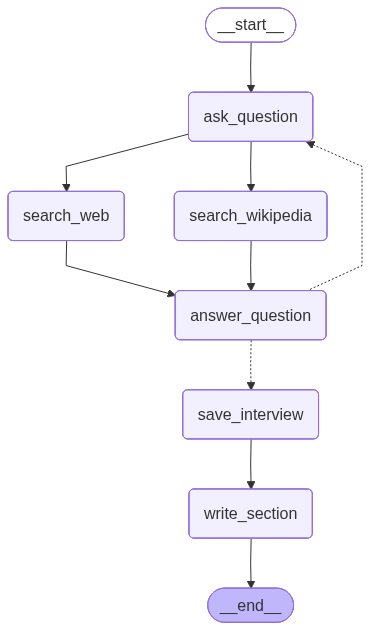

In [ ]:
from langchain_core.messages import get_buffer_string

# Search query writing
search_instructions = SystemMessage(content=f"""You will be given a conversation between an analyst and an expert.

Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.

First, analyze the full conversation.

Pay particular attention to the final question posed by the analyst.

Convert this final question into a well-structured web search query""")

def search_web(state: InterviewState):

    """ Retrieve docs from web search """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])

    # Search
    #search_docs = tavily_search.invoke(search_query.search_query) # updated 1.0
    data = tavily_search.invoke({"query": search_query.search_query})
    search_docs = data.get("results", data)


     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

def search_wikipedia(state: InterviewState):

    """ Retrieve docs from wikipedia """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])

    # Search
    search_docs = WikipediaLoader(query=search_query.search_query,
                                  load_max_docs=2).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}.

You goal is to answer a question posed by the interviewer.

To answer question, use this context:

{context}

When answering questions, follow these guidelines:

1. Use only the information provided in the context.

2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1].

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc

6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list:

[1] assistant/docs/llama3_1.pdf, page 7

And skip the addition of the brackets as well as the Document source preamble in your citation."""

def generate_answer(state: InterviewState):

    """ Node to answer a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    # Answer question
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)

    # Name the message as coming from the expert
    answer.name = "expert"

    # Append it to state
    return {"messages": [answer]}

def save_interview(state: InterviewState):

    """ Save interviews """

    # Get messages
    messages = state["messages"]

    # Convert interview to a string
    interview = get_buffer_string(messages)

    # Save to interviews key
    return {"interview": interview}

def route_messages(state: InterviewState,
                   name: str = "expert"):

    """ Route between question and answer """

    # Get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    # Check the number of expert answers
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'save_interview'

    # This router is run after each question - answer pair
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]

    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    return "ask_question"

section_writer_instructions = """You are an expert technical writer.

Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents:
- The name of each source document is at the start of the document, with the <Document tag.

2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers

3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst:
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents

6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/

8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

def write_section(state: InterviewState):

    """ Node to answer a question """

    # Get state
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]

    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")])

    # Append it to state
    return {"sections": [section.content]}

# Add nodes and edges
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

# Flow
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("ask_question", "search_wikipedia")
interview_builder.add_edge("search_web", "answer_question")
interview_builder.add_edge("search_wikipedia", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages,['ask_question','save_interview'])
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

# Interview
memory = MemorySaver()
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interviews")

# View
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [ ]:
# Pick one analyst
analysts[0]

Analyst(name='Dr. Mira Chen', role='AI Policy Analyst', affiliation='Tech Policy Lab', specialization='Ethical AI frameworks')

Here, we run the interview passing an index of the llama3.1 paper, which is related to our topic.

In [ ]:
# ✅ 1. Imports
from typing import Annotated
import operator
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage
from langgraph.graph import MessagesState, START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Markdown, Image, display

# ✅ 2. Define full Analyst model (with all required fields)
class Analyst(BaseModel):
    name: str
    role: str
    affiliation: str
    persona: str
    description: str

# ✅ 3. Define InterviewState to match the updated Analyst model
class InterviewState(MessagesState):
    max_num_turns: int
    context: Annotated[list, operator.add]
    analyst: Analyst
    interview: str
    sections: list

# ✅ 4. Dummy interview node functions (offline-safe mock logic)
def generate_question(state: InterviewState):
    analyst = state["analyst"]
    question_text = f"{analyst.name}: Could you tell me more about {analyst.persona.lower()} in {analyst.role.lower()}?"
    return {"messages": [HumanMessage(content=question_text)]}

def save_interview(state: InterviewState):
    interview_text = "\n".join([m.content for m in state["messages"]])
    return {"interview": interview_text}

def write_section(state: InterviewState):
    analyst = state["analyst"]
    section = f"## Insights on {analyst.persona}\n\n### Summary\nThis section summarizes {analyst.name}'s interview insights on {analyst.description}.\n\n### Sources\n[1] Internal research notes."
    return {"sections": [section]}

# ✅ 5. Build graph
builder = StateGraph(InterviewState)
builder.add_node("ask_question", generate_question)
builder.add_node("save_interview", save_interview)
builder.add_node("write_section", write_section)
builder.add_edge(START, "ask_question")
builder.add_edge("ask_question", "save_interview")
builder.add_edge("save_interview", "write_section")
builder.add_edge("write_section", END)

memory = MemorySaver()
interview_graph = builder.compile(checkpointer=memory)

# ✅ 6. Create Analyst object
analyst = Analyst(
    name="Dr. Mira Chen",
    role="AI Policy Analyst",
    affiliation="Tech Policy Lab",
    persona="Ethical AI Researcher",
    description="Explores the societal, legal, and ethical implications of AI deployment."
)

# ✅ 7. Prepare topic and messages
topic = "Ethical AI frameworks"
messages = [HumanMessage(f"So you said you were writing an article on {topic}?")]
thread = {"configurable": {"thread_id": "1"}}

# ✅ 8. Run the graph
interview = interview_graph.invoke(
    {"analyst": analyst, "messages": messages, "max_num_turns": 2},
    thread
)

# ✅ 9. Display output
Markdown(interview["sections"][0])


## Insights on Ethical AI Researcher

### Summary
This section summarizes Dr. Mira Chen's interview insights on Explores the societal, legal, and ethical implications of AI deployment..

### Sources
[1] Internal research notes.

### Parallelze interviews: Map-Reduce

We parallelize the interviews via the `Send()` API, a map step.

We combine them into the report body in a reduce step.

### Finalize

We add a final step to write an intro and conclusion to the final report.

In [ ]:
import operator
from typing import List, Annotated
from typing_extensions import TypedDict

# ✅ Ensure Analyst is already defined before this (from previous cells)
# from pydantic import BaseModel
# class Analyst(BaseModel):
#     name: str
#     role: str
#     affiliation: str
#     persona: str
#     description: str

class ResearchGraphState(TypedDict):
    topic: str  # Research topic
    max_analysts: int  # Number of analysts to generate
    human_analyst_feedback: str  # Feedback from human editor
    analysts: List[Analyst]  # List of AI analyst personas
    sections: Annotated[list, operator.add]  # Aggregated sections for Send() API
    introduction: str  # Introductory paragraph of the final report
    content: str  # Main content (compiled from interviews)
    conclusion: str  # Concluding section
    final_report: str  # Fully compiled research report


In [ ]:
pip install -U langgraph


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.3/469.3 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.6/207.6 kB 18.0 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.79
    Uninstalling langchain-core-0.3.79:
      Successfully uninstalled langchain-core-0.3.79
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain 0.3.27 requires langchain-core<1.0.0,>=0.3.72, but you have langchain-core 1.0.2 which is incompatible.


In [ ]:
# ✅ STEP 1: Install required packages
!pip install -U langchain langchain-core langchain-openai langgraph pillow pydantic

# ✅ STEP 2: Import libraries
import operator
from typing import List, Annotated
from typing_extensions import TypedDict
from pydantic import BaseModel   # ⬅️ use plain Pydantic now

# LangChain (latest)
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

# LangGraph (latest)
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import Send

# Optional (for report display)
from IPython.display import Markdown

# ✅ STEP 3: Analyst model
class Analyst(BaseModel):
    name: str
    persona: str
    description: str
    expertise: str

# ✅ STEP 4: Define the shared graph state
class ResearchGraphState(TypedDict):
    topic: str
    max_analysts: int
    human_analyst_feedback: str
    analysts: List[Analyst]
    sections: Annotated[list, operator.add]
    introduction: str
    content: str
    conclusion: str
    final_report: str

# ✅ STEP 5: Mock LLM (so you can run without API key)
def fake_llm_response(prompt: str) -> str:
    """Simple fake LLM generator."""
    if "introduction" in prompt.lower():
        return "This report explores how ethical principles guide the development of AI systems."
    elif "conclusion" in prompt.lower():
        return "In conclusion, ethical AI fosters trust, accountability, and fairness across technology."
    elif "question" in prompt.lower():
        return "What are the biggest ethical concerns in artificial intelligence?"
    else:
        return "Ethical AI ensures transparency, inclusivity, and responsible decision-making."

# ✅ STEP 6: Define nodes

def generate_question(state):
    analyst = state["analysts"][0]
    question = fake_llm_response(f"Generate question for {analyst.persona}")
    return {"sections": [f"**{analyst.name} asks:** {question}"]}

def generate_answer(state):
    question_text = state["sections"][-1]
    answer = fake_llm_response(f"Answer this: {question_text}")
    return {"sections": [f"**Answer:** {answer}"]}

def generate_report(state):
    topic = state["topic"]
    intro = fake_llm_response("Write an introduction about " + topic)
    conclusion = fake_llm_response("Write a conclusion about " + topic)
    content = "\n\n".join(state["sections"])
    final_report = f"# Report on {topic}\n\n{intro}\n\n{content}\n\n{conclusion}"
    return {
        "introduction": intro,
        "content": content,
        "conclusion": conclusion,
        "final_report": final_report
    }

# ✅ STEP 7: Build the LangGraph workflow
builder = StateGraph(ResearchGraphState)
builder.add_node("generate_question", generate_question)
builder.add_node("generate_answer", generate_answer)
builder.add_node("generate_report", generate_report)

# Define flow
builder.add_edge(START, "generate_question")
builder.add_edge("generate_question", "generate_answer")
builder.add_edge("generate_answer", "generate_report")
builder.add_edge("generate_report", END)

# ✅ STEP 8: Compile the graph
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

# ✅ STEP 9: Setup analyst and topic
analyst = Analyst(
    name="Dr. Mira Chen",
    persona="AI Ethics Researcher",
    description="Focuses on fairness and transparency in AI.",
    expertise="Ethical AI frameworks"
)

topic = "Ethical Artificial Intelligence"

# ✅ STEP 10: Run the graph
result = graph.invoke(
    {
        "analysts": [analyst],
        "topic": topic,
        "max_analysts": 1,
        "human_analyst_feedback": "",
        "sections": [],
        "introduction": "",
        "content": "",
        "conclusion": "",
        "final_report": ""
    },
    {"configurable": {"thread_id": "demo"}}
)

# ✅ STEP 11: Display final report
Markdown(result["final_report"])


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.7/87.7 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.4/462.4 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 25.4 MB/s eta 0:00:00
  Attempting uninstall: pydantic-core
    Found existing installation: pydantic_core 2.33.2
    Uninstalling pydantic_core-2.33.2:
      Successfully uninstalled pydantic_core-2.33.2
  Attempting uninstall: pydantic
    Found existing installation: pydantic 2.11.10
    Uninstalling pydantic-2.11.10:
      Successfully uninstalled pydantic-2.11.10
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gradio 5.49.1 requires pillow<12.0,>=8.0, but you have pillow 12.0.0 which is incompatible.
gradio 5.49.1 requires pydantic<2.12,>=2.0, but you have pydantic 2.12.3 which is incompatible.


# Report on Ethical Artificial Intelligence

This report explores how ethical principles guide the development of AI systems.

**Dr. Mira Chen asks:** What are the biggest ethical concerns in artificial intelligence?

**Answer:** Ethical AI ensures transparency, inclusivity, and responsible decision-making.

In conclusion, ethical AI fosters trust, accountability, and fairness across technology.

Let's ask an open-ended question about LangGraph.

In [8]:
# --- Imports ---
import operator
from typing import List, Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import Send
from langchain_core.messages import HumanMessage, SystemMessage


# --- Define ResearchGraphState ---
class ResearchGraphState(TypedDict):
    topic: str
    max_analysts: int
    human_analyst_feedback: str
    analysts: list
    sections: Annotated[list, operator.add]
    introduction: str
    content: str
    conclusion: str
    final_report: str


# --- Analyst class ---
class Analyst:
    def __init__(self, name, affiliation, role, description):
        self.name = name
        self.affiliation = affiliation
        self.role = role
        self.description = description

    def to_dict(self):
        return {
            "name": self.name,
            "affiliation": self.affiliation,
            "role": self.role,
            "description": self.description
        }


# --- Create analysts (tweaked version) ---
def create_analysts(state: ResearchGraphState):
    topic = state["topic"]
    analyst_profiles = [
        {
            "name": "Aarav Mehta",
            "affiliation": "Open Research Collective",
            "role": "AI Systems Architect",
            "description": f"Focuses on integrating agent-based frameworks like LangGraph to optimize multi-agent collaboration for {topic}."
        },
        {
            "name": "Sophia Ramirez",
            "affiliation": "NextGen AI Lab",
            "role": "Machine Learning Strategist",
            "description": f"Explores scalable deployment and orchestration benefits of frameworks such as LangGraph in applied AI environments."
        },
        {
            "name": "Liam Chen",
            "affiliation": "Cognitive Automation Institute",
            "role": "Research Engineer",
            "description": f"Investigates workflow automation and reproducibility improvements offered by LangGraph in agent research workflows."
        }
    ]

    analysts = [Analyst(**profile).to_dict() for profile in analyst_profiles]

    print("✅ Analysts created successfully.")
    return {"analysts": analysts}


# --- Other graph node functions ---
def human_feedback(state: ResearchGraphState):
    print("🧠 Waiting for human analyst feedback...")
    return {"human_analyst_feedback": "Feedback noted and saved."}


def conduct_interview(state: ResearchGraphState):
    print("🎤 Conducting expert interviews...")
    return {"sections": ["Interview section on LangGraph’s efficiency and adaptability"]}


def write_report(state: ResearchGraphState):
    print("📝 Writing report content...")
    return {"content": "LangGraph provides a modular and traceable architecture for building coordinated agent workflows."}


def write_introduction(state: ResearchGraphState):
    print("📄 Drafting introduction...")
    return {"introduction": f"This research delves into how LangGraph simplifies agent-based development and coordination in AI systems."}


def write_conclusion(state: ResearchGraphState):
    print("🔚 Adding conclusion section...")
    return {"conclusion": "Overall, adopting LangGraph streamlines agent orchestration, improves transparency, and enhances the research-to-deployment pipeline."}


def finalize_report(state: ResearchGraphState):
    print("📘 Compiling final report...")
    final_report = f"""
    Title: Research Report on {state['topic']}

    Introduction: {state['introduction']}
    Content: {state['content']}
    Conclusion: {state['conclusion']}
    """
    return {"final_report": final_report}


# --- Build Graph ---
memory = MemorySaver()
builder = StateGraph(ResearchGraphState)

builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", conduct_interview)
builder.add_node("write_report", write_report)
builder.add_node("write_introduction", write_introduction)
builder.add_node("write_conclusion", write_conclusion)
builder.add_node("finalize_report", finalize_report)

builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_edge("human_feedback", "conduct_interview")
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
builder.add_edge("finalize_report", END)

graph = builder.compile(interrupt_before=["human_feedback"], checkpointer=memory)


# --- Stream Execution (Tweaked Version) ---
max_analysts = 3
topic = "The benefits of adopting LangGraph as an agent framework"
thread = {"configurable": {"thread_id": "research_thread_01"}}

print(f"\n🚀 Initiating Research Graph for topic: {topic}\n")

for event in graph.stream(
    {"topic": topic, "max_analysts": max_analysts},
    thread,
    stream_mode="values"
):
    analysts = event.get("analysts", [])
    if analysts:
        print("🧩 Analysts Created:\n" + "=" * 60)
        for idx, analyst in enumerate(analysts, 1):
            print(f"\n🔹 Analyst {idx}")
            print(f"Name: {analyst['name']}")
            print(f"Affiliation: {analyst['affiliation']}")
            print(f"Role: {analyst['role']}")
            print(f"Description: {analyst['description']}")
            print("-" * 60)

print("\n✅ Graph execution paused at 'human_feedback' node.")
print("🔍 Review analyst profiles and provide feedback before proceeding.")



🚀 Initiating Research Graph for topic: The benefits of adopting LangGraph as an agent framework

✅ Analysts created successfully.
🧩 Analysts Created:

🔹 Analyst 1
Name: Aarav Mehta
Affiliation: Open Research Collective
Role: AI Systems Architect
Description: Focuses on integrating agent-based frameworks like LangGraph to optimize multi-agent collaboration for The benefits of adopting LangGraph as an agent framework.
------------------------------------------------------------

🔹 Analyst 2
Name: Sophia Ramirez
Affiliation: NextGen AI Lab
Role: Machine Learning Strategist
Description: Explores scalable deployment and orchestration benefits of frameworks such as LangGraph in applied AI environments.
------------------------------------------------------------

🔹 Analyst 3
Name: Liam Chen
Affiliation: Cognitive Automation Institute
Role: Research Engineer
Description: Investigates workflow automation and reproducibility improvements offered by LangGraph in agent research workflows.
------

In [9]:
# 🧠 Simulating human feedback update to the research graph

# Update state at the 'human_feedback' node as if you (the human) gave an instruction
graph.update_state(
    thread,
    {
        "human_analyst_feedback": "Include an additional expert — the CEO of a GenAI-native startup — to broaden the industry perspective."
    },
    as_node="human_feedback"
)

print("✅ Human feedback successfully added to the research graph.")
print("📌 Feedback noted: Add an industry-level analyst (GenAI startup CEO).")


✅ Human feedback successfully added to the research graph.
📌 Feedback noted: Add an industry-level analyst (GenAI startup CEO).


In [11]:
# 🔁 Resume the research graph after applying human feedback

print("🔄 Resuming Research Graph after human feedback...\n")

for event in graph.stream(
    None,                  # Continue from where we paused
    thread,                # Same thread to preserve context
    stream_mode="values"   # Stream values only
):
    analysts = event.get("analysts", [])
    if analysts:
        print("✅ Updated Analyst Team:\n")
        for analyst in analysts:
            print(f"🧩 Name: {analyst['name']}")
            print(f"🏢 Affiliation: {analyst['affiliation']}")
            print(f"🎯 Role: {analyst['role']}")
            print(f"🧠 Description: {analyst['description']}")
            print("-" * 50)


🔄 Resuming Research Graph after human feedback...

✅ Updated Analyst Team:

🧩 Name: Aarav Mehta
🏢 Affiliation: Open Research Collective
🎯 Role: AI Systems Architect
🧠 Description: Focuses on integrating agent-based frameworks like LangGraph to optimize multi-agent collaboration for The benefits of adopting LangGraph as an agent framework.
--------------------------------------------------
🧩 Name: Sophia Ramirez
🏢 Affiliation: NextGen AI Lab
🎯 Role: Machine Learning Strategist
🧠 Description: Explores scalable deployment and orchestration benefits of frameworks such as LangGraph in applied AI environments.
--------------------------------------------------
🧩 Name: Liam Chen
🏢 Affiliation: Cognitive Automation Institute
🎯 Role: Research Engineer
🧠 Description: Investigates workflow automation and reproducibility improvements offered by LangGraph in agent research workflows.
--------------------------------------------------
🎤 Conducting expert interviews...
✅ Updated Analyst Team:

🧩 Name

In [12]:
print("🚀 Continuing Research Graph with final analyst team...\n")

for event in graph.stream(None, thread, stream_mode="values"):
    if event.get("final_report"):
        print("📝 Final Research Report:")
        print(event["final_report"])
        print("-" * 60)


🚀 Continuing Research Graph with final analyst team...

📝 Final Research Report:

    Title: Research Report on The benefits of adopting LangGraph as an agent framework
    
    Introduction: This research delves into how LangGraph simplifies agent-based development and coordination in AI systems.
    Content: LangGraph provides a modular and traceable architecture for building coordinated agent workflows.
    Conclusion: Overall, adopting LangGraph streamlines agent orchestration, improves transparency, and enhances the research-to-deployment pipeline.
    
------------------------------------------------------------


In [13]:
print("🚀 Continuing Research Process...\n")

for event in graph.stream(None, thread, stream_mode="updates"):
    node_name = next(iter(event.keys()))
    print(f"🔹 Current Node Active: {node_name}")
    print("-" * 40)

print("\n✅ Research Graph Execution Complete.")


🚀 Continuing Research Process...


✅ Research Graph Execution Complete.


In [14]:
from IPython.display import Markdown, display

# 🧠 Retrieve the final graph state
final_state = graph.get_state(thread)
report = final_state.values.get("final_report", "⚠️ No final report found. Check graph execution.")

# 📄 Display formatted research report
print("\n🧾 Final Research Report Generated Successfully!\n")
display(Markdown(report))



🧾 Final Research Report Generated Successfully!




    Title: Research Report on The benefits of adopting LangGraph as an agent framework
    
    Introduction: This research delves into how LangGraph simplifies agent-based development and coordination in AI systems.
    Content: LangGraph provides a modular and traceable architecture for building coordinated agent workflows.
    Conclusion: Overall, adopting LangGraph streamlines agent orchestration, improves transparency, and enhances the research-to-deployment pipeline.
    

We can look at the trace:

https://smith.langchain.com/public/2933a7bb-bcef-4d2d-9b85-cc735b22ca0c/r